In [13]:
import os
import re
import sys
import time
import shutil
import copy
import glob
import numpy as np
import itertools
import importlib
import multiprocessing

import segyio
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy import signal, ndimage
from natsort import natsorted
sys.path.append(os.path.abspath('./utils'))
import shared as sd
import loaders as ld
import vis

from IPython.display import clear_output

# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
print(f'Python: {sys.prefix}')
# import m8r as sf

Python: /home/plotnips/anaconda3/envs/lw


/tmp/ipykernel_42536/3885816846.py:15: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [14]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [15]:
root_out = '/home/ovcharoo/work/data/'
print(os.getcwd())
root_field = os.path.join('./data_cgg/')

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha


In [16]:
# Time sampling in ML application
dt_net = 0.016

In [17]:
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True

def divmax(x): return x / np.max(np.abs(x))
    
def load_bin(p, dims): 
    f = open(p); vp = np.fromfile (f, dtype=np.dtype('float32').newbyteorder ('<')); f.close();
    vp = vp.reshape(*dims); vp = np.transpose(vp); vp = np.flipud(vp); print(f"{vp.shape}"); return vp

def plot_model(v, title='', axis='on', **kwargs): 
    plt.figure(); ax = plt.gca(); im = ax.imshow(np.flipud(v), cmap='RdBu_r', **kwargs); plt.axis(axis); plt.title(title); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);plt.colorbar(im, cax=cax); plt.pause(0.001)
    return ax

def plot_logs(m1, m2, idx=2, title=''):
    plt.figure(); plt.plot(m1.vp[::-1,idx], 'k--'); plt.plot(m1.vs[::-1,idx], 'k--'); plt.plot(m1.rho[::-1,idx], 'k--');
    plt.plot(m2.vp[::-1,idx], label='vp'); plt.plot(m2.vs[::-1,idx], label='vs'); plt.plot(m2.rho[::-1,idx], label='rho'); plt.legend() 

# Load initial model

Load ./data_cgg/cgg_tomo.hh
	dim: 2
	dict['n1'] <-- n1 <-- 300
	dict['d1'] <-- d1 <-- 12.5
	dict['o1'] <-- o1 <-- 0
	dict['n2'] <-- n2 <-- 1000
	dict['d2'] <-- d2 <-- 12.5
	dict['o2'] <-- o2 <-- 0
	data <-- (300, 1000)
(152, 600)
nz0=152, nx0=600
(152, 600)
1490.0
(152, 600)


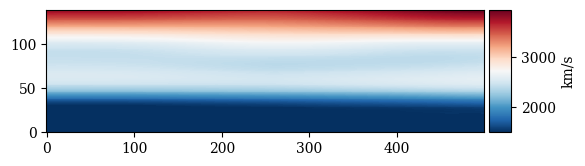

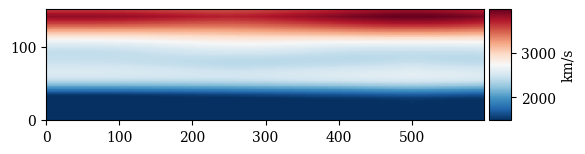

In [18]:
dx = 12.5
vp, _ = ld.load_hh(os.path.join(root_field, 'cgg_tomo.hh'), 1)
vp = np.flipud(vp.T)[::1, ::1] * 1000

# Downsample
factor = 2
ndown = 10
dx = dx * factor
vp = vp[::factor, ::factor]
vp = vp[:-ndown, :]

vis.plot_model(np.flipud(vp))
# print(vp.shape)

def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x

ndeeper = 2
nexp = 100
vp_cgg = extend(vp, ndeeper, 0)
vp_cgg = np.concatenate((np.flip(vp_cgg[:ndown, :], 0), vp_cgg), 0)  # OZ
vp_cgg = np.where(vp_cgg < 1490.0, 1490.0, vp_cgg)
tmp = extend(vp_cgg, 0, nexp)
print(tmp.shape)

# taper0 = tmp[:,:500] < 1.01 * np.min(tmp[:,:500])
taper0 = tmp < 1.01 * np.min(tmp)


# tmp = extend(vp, ndeeper, 0)
# print(tmp.shape)
vis.plot_model(np.flipud(tmp))
vp = tmp.copy()
nz0, nx0 = vp.shape
print(f'nz0={nz0}, nx0={nx0}')
print(taper0.shape)
print(vp_cgg.min())
print(vp.shape)

# Well-log model

In [19]:
lvp, _ = ld.load_hh(os.path.join(root_field, 'cgg_log.hh'), 1)
lvp = np.flipud(lvp.T)

lvp = lvp[::factor, :]
lvp = lvp[:-5, :nx0]
print(lvp.shape)

# shear velocity, [m/s]
lvs = lvp.copy() / (3 ** 0.5)
lvs = np.where(lvp < 1.01 * np.min(lvp), 0, lvs)

# density, [kg/m3] 
lrho = 1e3*0.3 * lvp.copy()**0.25
lrho = np.where(lvp < 1.01 * np.min(lvp), 1000, lrho)
model_log = api.Model(lvp, lvs, lrho, dx)

Load ./data_cgg/cgg_log.hh
	dim: 2
	dict['n1'] <-- n1 <-- 241
	dict['d1'] <-- d1 <-- 12.5
	dict['o1'] <-- o1 <-- 0
	dict['n2'] <-- n2 <-- 800
	dict['d2'] <-- d2 <-- 12.5
	dict['o2'] <-- o2 <-- 0
	data <-- (241, 800)
(116, 600)


In [20]:
log_loc = 10500 # m
log_idx = int(log_loc / dx)
# plot_logs(model_log, model_cgg, log_idx, title='Initial vs well-log')

In [21]:
# # model = api.Model(vp, vs, rho, dx)
# model = copy.deepcopy(model_cgg)
# print(model)

# nz, nx = vp.shape
# vplim = {'vmax': model.vp.max()/1000, 'vmin': model.vp.min()/1000}
# vslim = {'vmax': model.vs.max()/1000, 'vmin': model.vs.min()/1000}
# rholim = {'vmax': model.rho.max()/1000, 'vmin': model.rho.min()/1000}
# vlims = {'vp': vplim, 'vs': vslim, 'rho': rholim}
# print(f'size:\t{(nz,nx)}\nvp:\t{vplim}\nvs:\t{vslim}\nrho:\t{rholim}')

# Data

In [22]:
filename = '/home/ovcharoo/Dropbox/swag_datasets/CGG_NW_Australia/bdata.segy'

In [23]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

In [24]:
# Parsing 15 Gb data, takes some time!
hname = os.path.join(root_field, 'trace_headers.pkl')
trace_headers = sd.load_object(hname)

# if trace_headers is None:
#     t1 = time.time()
#     with segyio.open(filename, ignore_geometry=True) as f:
#         # Get basic attributes
#         n_traces = f.tracecount
#     #     sample_rate = segyio.tools.dt(f) / 1000
#     #     n_samples = f.samples.size
#     #     twt = f.samples
#     #     data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
#         # Load headers
#         bin_headers = f.bin
#     #     text_headers = parse_text_header(f)
#         trace_headers = parse_trace_headers(f, n_traces)

if trace_headers is None:
    t1 = time.time()
    with segyio.open(filename, ignore_geometry=True) as f:
        n_traces = f.tracecount
        trace_headers = parse_trace_headers(f, n_traces)
    save_object(trace_headers, hname)
    print(f'Elapsed time: {time.time() - t1} sec')

Load obj from ./data_cgg/trace_headers.pkl


Creating a segy file is a headache. Have to fill in filelds in segyio.spec() to send it as second argument in segyio.create(fname, spec)

In [25]:
with segyio.open(filename, ignore_geometry=True) as f:
    print('\n'.join([str(s) for s in [f.sorting, 
                                      f.format, 
                                      f.samples.shape,
                                     f.ilines,
                                     f.xlines,
                                     f.tracecount,
#                                      f.text[0],
                                     f.header]]))

PermissionError: [Errno 13] Permission denied

In [ ]:
# header for whole dataset
# bin_headers

In [ ]:
# header of each trace
trace_headers.head()

In [ ]:
# list keys in header
trace_headers.keys()

In [ ]:
# Drop empty columns
th = trace_headers.loc[:, (trace_headers != 0).any(axis=0)]
th = th.loc[:, (trace_headers != 1).any(axis=0)]
th = th.drop(['TRACE_SEQUENCE_LINE', 'CDP_X', 
              'CDP_Y', 'CDP', 'INLINE_3D', 
              'CROSSLINE_3D', 'FieldRecord'], axis=1)
print(f'Drop empty cols! {len(trace_headers.keys())} --> {len(th.keys())}')

In [ ]:
th.head()

In [ ]:
# Convert depths to meters (multiplied by 10 by default)
th[['SourceWaterDepth', 'GroupWaterDepth']] = th[['SourceWaterDepth', 'GroupWaterDepth']].divide(10.)
# Init TraceNumber (rec id within a shot gather) to start from 0 rather form 1
th['TraceNumber'] = th['TraceNumber'].sub(1)
th['TRACE_SEQUENCE_FILE'] = th['TRACE_SEQUENCE_FILE'].sub(1)

In [ ]:
th.describe()

In [ ]:
th.keys()

In [ ]:
dDT = th['TRACE_SAMPLE_INTERVAL'].unique()[0] / 1e6
print(f'dt = {dDT} sec')

In [ ]:
dNT = th['TRACE_SAMPLE_COUNT'].unique()[0]
print(f'nt = {dNT}')

In [ ]:
# Get coordinates of all sources
xsrc = th['SourceX'].copy()
ysrc = th['SourceY'].copy()
print(f'Raw:\nSourceX --> min: {xsrc.min()}\t\tmax: {xsrc.max()}')
print(f'SourceY --> min: {ysrc.min()}\tmax: {ysrc.max()}')

xsrc = xsrc - xsrc.min()
ysrc = ysrc - ysrc.min()

rsrc = ((xsrc.to_numpy() - xsrc.to_numpy()[0]) ** 2 + (ysrc.to_numpy() - ysrc.to_numpy()[0]) ** 2) ** 0.5

th['SourceX0'] = xsrc
th['SourceY0'] = ysrc
th['SourceX1D'] = rsrc

print(f'\nCenter around zero:\nSourceX --> min: {xsrc.min()}\tmax: {xsrc.max()}')
print(f'SourceY --> min: {ysrc.min()}\tmax: {ysrc.max()}')
print(f'\n2D --> 1D:\tmin: {rsrc.min()}\tmax: {rsrc.max()}')

In [ ]:
# Get coordinates of all receivers
xsrc = th['GroupX'].copy()
ysrc = th['GroupY'].copy()
print(f'Raw:\nGroupX --> min: {xsrc.min()}\t\tmax: {xsrc.max()}')
print(f'GroupY --> min: {ysrc.min()}\tmax: {ysrc.max()}')

xsrc = xsrc - xsrc.min()
ysrc = ysrc - ysrc.min()

rsrc = ((xsrc.to_numpy() - xsrc.to_numpy()[0]) ** 2 + (ysrc.to_numpy() - ysrc.to_numpy()[0]) ** 2) ** 0.5

th['GroupX0'] = xsrc
th['GroupY0'] = ysrc
th['GroupX1D'] = rsrc
# th['ReceiverX1D'] = th['GroupX1D'] + 168.
th['ReceiverX1D'] = th['GroupX1D'] + 175.

print(f'\nCenter around zero:\nGroupX --> min: {xsrc.min()}\tmax: {xsrc.max()}')
print(f'GroupY --> min: {ysrc.min()}\tmax: {ysrc.max()}')
print(f'\n2D --> 1D:\tmin: {rsrc.min()}\tmax: {rsrc.max()}')

del xsrc, ysrc

In [ ]:
nsrc = len(th.SourceX0.unique())
xsrc = th.SourceX0.unique()
ysrc = th.SourceY0.unique()
print(f'nsrc = {nsrc}')
plt.figure(); plt.scatter(xsrc, ysrc); plt.title('Line of sources in 2D'); plt.ylabel('SourceY0'); plt.xlabel('SourceX0');
plt.text(xsrc[0], ysrc[0], '0'); plt.text(xsrc[-1], ysrc[-1], '-1');

In [ ]:
xsrc_raw = np.array(sorted(th.SourceX0.unique()))
ysrc_raw = np.array(sorted(th.SourceY0.unique()))
rsrc_raw = np.sqrt(xsrc_raw ** 2 + ysrc_raw ** 2)
print(f'xsrc_raw ({len(xsrc_raw)})\n\t{xsrc_raw.min()} m\t{xsrc_raw.max()} m')
print(f'ysrc_raw ({len(ysrc_raw)})\n\t{ysrc_raw.min()} m\t{ysrc_raw.max()} m')
print(f'rsrc_raw ({len(rsrc_raw)})\n\t{rsrc_raw.min()} m\t{rsrc_raw.max()} m')

dsrc_raw = np.round(np.mean(rsrc_raw[1:] - rsrc_raw[:-1]), 2)

print('\nSource spacing: {} m'.format(dsrc_raw))

In [ ]:
# rsrc_raw[53] / (dx)

In [ ]:
every_nth_src_spacing = [dsrc_raw * i for i in [4, 8]]

# Suitable grid spacings to have sources placed in grid nodes
print('Suitable spacing between sources for grid step of 25 m:\t' + ', '.join([str(np.round(s)) for s in every_nth_src_spacing]))

In [ ]:
th.keys()

In [ ]:
# Remove redundant columns
drop_list = ['SourceX', 'SourceY',
             'SourceX0', 'SourceY0',
             'GroupX', 'GroupY',
             'GroupX0', 'GroupY0',
             'MuteTimeStart',
             'MuteTimeEND']
print(drop_list)
th = th.drop(drop_list, axis=1, errors='ignore')
th.head()

In [ ]:
# Group shots
th['SHOT_ID'] = th.groupby('SourceX1D').ngroup()
print(f'Assign SHOT_IDs for {th.SHOT_ID.nunique()} shots')

# Replicate Mahesh's setup
Keep first 576 shots

In [ ]:
# Select shots, about like in Mahesh's paper
# https://academic.oup.com/gji/article/210/3/1581/3829893?login=true

# Old
# shot_id_min = 60
# shot_id_max = 680

# shot_id_min = 60
# n_selected_shots = 64
# njump_src = 8 # because spacing between sources is 18.75 and 6 maps well on grid nodes spaced by 25 m
# shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

print(f'Select {n_selected_shots} shots in range {shot_id_min}..{shot_id_max}')

th = th.drop(th[th['SHOT_ID'] < shot_id_min].index)
th = th.drop(th[th['SHOT_ID'] >= shot_id_max].index)

nsrc = th.SHOT_ID.nunique()
src_id_min = th.SHOT_ID.unique().min()
src_id_max = th.SHOT_ID.unique().max()
print(f'Remaining shots - first {nsrc}, {src_id_min}..{src_id_max}')

In [ ]:
# Plot zero-offset section
shot_ids = natsorted(th.SHOT_ID.unique())
zero_offset = np.zeros((len(shot_ids), dNT))
print(f'Zero-offset section {zero_offset.shape}')
with segyio.open(filename, ignore_geometry=True) as f:
    for ishot, shot_id in enumerate(shot_ids):
        _shot = th[th.SHOT_ID == shot_id]
        id_min = _shot.TRACE_SEQUENCE_FILE.min()
        zero_offset[ishot, :] = f.trace.raw[id_min:id_min + 1]
vis.plot_shot(zero_offset, pclip=0.01, figsize=(8,2), colorbar=False)
vis.plot_shot(zero_offset[-200:, :], pclip=0.01, figsize=(8,2), colorbar=False)

In [ ]:
wb = []
xb = []
with segyio.open(filename, ignore_geometry=True) as f:
    for ishot, shot_id in enumerate(range(src_id_min, src_id_max)):
        _shot = th[th.SHOT_ID == shot_id]
        id_min = _shot.TRACE_SEQUENCE_FILE.min()
        s = f.trace.raw[id_min:id_min + 10]
        time_idx_start = 350 # 450
        s = s[:, time_idx_start:800]
        amax = np.argmax(np.sum(s, 0))
        wb.append(amax + time_idx_start)
        xb.append(_shot['ReceiverX1D'][0:1])
wb_p = [int(np.floor(_wb * 0.002 / 2 * np.min(vp_cgg) / dx)) for _wb in wb]
# plt.figure(); plt.plot(xb, wb_p); plt.gca().invert_yaxis()

# sort water bottom
wb_reverse = copy.copy(wb_p)
# plt.figure(); plt.plot(xb, wb_reverse); plt.gca().invert_yaxis()

new_bottom = [wb_reverse[0]]
for ipoint in range(1, len(wb_reverse)):
    this_point = wb_reverse[ipoint]

    if this_point > new_bottom[-1]:
        new_bottom.append(new_bottom[-1])
    else:
        new_bottom.append(this_point)
plt.figure(); plt.plot(xb, new_bottom); plt.gca().invert_yaxis();
wb_p = copy.copy(new_bottom)
    

In [ ]:
print(np.min(wb_p), np.max(wb_p), len(wb_p))
print(np.min(xb), np.max(xb), len(xb))

xbb = np.array([_xb.to_list()[0] for _xb in xb])

# for every pixel along OX of velocity model
# xv = [i*dx for i in range(nx0 - nexp)]
xv = [i*dx for i in range(nx0)]
# find nearest known water depth
# wb_taper = np.zeros_like(taper0)
wb_taper = np.zeros_like(vp)
wb_args = []
for ix, x in enumerate(xv):
    arg = np.argmin(np.abs(xbb - x))
    wb_args.append(wb_p[arg]-1)
    wb_taper[-wb_p[arg]-1:, ix] = 1.
plt.figure(); plt.imshow(np.flip(wb_taper, 0));

print(wb_taper.shape)

# vis.plot_model(taper0 - wb_taper.astype(np.float), title='Diff water layer prev vs my')

In [ ]:
log = vp_cgg[:, 0:1]
print(log.shape)
vmin = np.min(log)
vmax = np.max(log)
vps = []
for wb in wb_args:
    fun = vmin * np.ones_like(log)
    fun[wb:, :] = 450 + fun[wb:, :] + 12 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    vps.append(fun[::-1, :])
vp = np.concatenate(vps, -1)
print(vp.shape)

In [ ]:
# actual location is 10500 m. The
wlog = lvp[:, 0:1]

vmin = np.min(log)
vmax = np.max(log)
vps = []
print(vp.shape)
print(vp_cgg.shape)
for i in range(vp.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i])
    fun = vmin * np.ones_like(log)
#     fun[wb:, :] = 575 + fun[wb:, :] + 8 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun[wb:, :] = 605 + fun[wb:, :] + 7 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
#     vps.append(np.maximum(fun, log))
    vps.append(fun)
vp = np.concatenate(vps, -1)

print(vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(vp[-len(wlog):, log_idx])

In [ ]:
vps = []
print(vp.shape)
print(vp_cgg.shape)
for i in range(vp.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i])
    fun = vmin * np.ones_like(log)
#     fun[wb:, :] = 575 + fun[wb:, :] + 8 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun[wb:, :] = 605 + fun[wb:, :] + 7 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
#     vps.append(np.maximum(fun, log))
    vps.append(fun)
vp = np.concatenate(vps, -1)

print(vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(vp[-len(wlog):, log_idx])

In [ ]:
plt.figure(); 
xvec = np.arange(len(wlog)) * dx / 1000
plt.plot(xvec, wlog / 1000, 'k--');
plt.plot(xvec, vp[-len(wlog):, log_idx] / 1000, 'r'); 
plt.legend(['Well-log', 'Initial']); plt.ylabel('km/s'); plt.xlabel('km');
vis.savefig('logvsinit.png')

In [ ]:
vs = vp.copy() / (3 ** 0.5)
rho = 1e3*0.3 * vp.copy()**0.25

print(wb_taper.shape, vp.shape)
# vp = extend(np.where(wb_taper, np.min(vp_cgg), vp), 0, nexp)
# vs = extend(np.where(wb_taper, 0, vs), 0, nexp)
# rho = extend(np.where(wb_taper, 1000, rho), 0, nexp)
vp = np.where(wb_taper, np.min(vp_cgg), vp)
vs = np.where(wb_taper, 0, vs)
rho = np.where(wb_taper, 1000, rho)

# s, w = 2, 5
s, w = 3, 7
sigma_truncate = {'sigma': s, 'truncate': (((w - 1)/2)-0.5)/s}
vp = gaussian_filter(vp.copy(), **sigma_truncate)
vs = gaussian_filter(vs.copy(), **sigma_truncate)
rho = gaussian_filter(rho.copy(), **sigma_truncate)

print(vp.shape)
vshift = 2
vp = extend(vp, vshift, 0)[vshift:]
vs = extend(vs, vshift, 0)[vshift:]
rho = extend(rho, vshift, 0)[vshift:]
print(vp.shape)

model = api.Model(vp, vs, rho, dx)
print(vp.shape)
vis.plot_model(np.concatenate((vp, vs, rho), 0))

fig = plt.figure(); 
plt.plot(wlog, 'k--', label='Well')
plt.plot(log[-len(wlog):], 'k', label='Tomo')
plt.plot(vp[-len(wlog):, log_idx], 'r', label='Init')
# plt.plot(vp_[-len(wlog):, log_idx], 'b', label='New init')
# fig.colorbar()

In [ ]:
print(np.min(vp))

# Select shots for inversion

In [ ]:
# n_selected_shots = 56
# n_selected_shots = 112
print(f'Select {n_selected_shots} shots from {src_id_min} to {src_id_max}')

In [ ]:
print(src_id_min, src_id_max, n_selected_shots, njump_src)
selected_ids = [int(np.floor(x)) for x in np.linspace(src_id_min, src_id_max, n_selected_shots)]

ths = th.loc[th['SHOT_ID'].isin(selected_ids)]
print(f'Shots selected {len(selected_ids)}:\n\t{selected_ids[0]}..{selected_ids[-1]}\n\t{selected_ids}')

In [ ]:
actual_shot_locations = np.concatenate([ths[ths.SHOT_ID == shot_id].SourceX1D.unique() for shot_id in selected_ids])
# print(actual_shot_locations)

In [ ]:
# print(actual_shot_locations[1:] - actual_shot_locations[:-1])

In [ ]:
# print(src_id_min, src_id_min + (n_selected_shots-1) * njump_src, n_selected_shots, njump_src)
# selected_ids = [int(np.floor(x)) for x in np.linspace(src_id_min, src_id_min + (n_selected_shots-1) * njump_src, n_selected_shots)]

resulting_src_spacings = [a-b for a,b in zip(selected_ids[1:], selected_ids[:-1])]
print(f'Grid nodes between sources:\n\tmin={min(resulting_src_spacings)} == max={max(resulting_src_spacings)}?')

In [ ]:
# take 1 shot and visualize streamer
shot_id = selected_ids[0]
print(f'Look at shot {shot_id}')
shot = ths[ths.SHOT_ID == shot_id]

plt.figure(); plt.gca().invert_yaxis();
plt.scatter(shot.SourceX1D, shot.SourceWaterDepth); 
plt.scatter(shot.ReceiverX1D, shot.GroupWaterDepth);
plt.title('Streamer')

In [ ]:
# Read data for this shot
with segyio.open(filename, ignore_geometry=True) as f:
    id_min = shot.TRACE_SEQUENCE_FILE.min()
    id_max = shot.TRACE_SEQUENCE_FILE.max() + 1
    print(f'Read traces {id_min}:{id_max}')
    shot_data = f.trace.raw[id_min:id_max]
print(shot_data.shape)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
vis.plot_shot(ld.bandpass(shot_data, fs=1/dDT, fhi=15, btype='low'), dt=dDT, dx=12.5, pclip=0.05, colorbar=False, ax=ax[0]);
# vis.savefig('raw_shot.png')

vis.plot_spectra_dictlist([{'data': shot_data, 'line': 'navy', 'label': 'Raw data'}], dt=dDT, fmax=100., norm=True, ax=ax[1])
# vis.savefig('raw_spec.png')

# Source wavelet
Thanks Mahesh Kalita and Abdullah Alalai!

In [ ]:
wavelets, opts = ld.load_hh(os.path.join(root_field, 'kwlt10p0.hh'))
print(f'Load wavelet for unknown set of shots: {wavelets.shape}.\nParameters: {opts}')

In [ ]:
vis.plot_shot(wavelets, title='Wavelet for first 704 shots');

In [ ]:
def plot_wavelet(x, y, title=''):
    plt.figure(); plt.plot(x, y); 
    plt.xlabel('Time, sec'); plt.title(title);

wavelet = np.mean(wavelets, axis=0, keepdims=True) / 1e4
nt_wavelet = opts['n1']
dt_wavelet = opts['d1']
ax_t = np.arange(0, nt_wavelet)[..., np.newaxis]*dt_wavelet
plot_wavelet(ax_t, wavelet.T, 'Mean source wavelet')

In [ ]:
_nt = 1000 # time steps to zoom in
_ws = wavelets[:, 4:_nt] / 1e4
_ax_t = ax_t[4:_nt, :].squeeze()
plt.figure(figsize=(6, 3)); plt.fill_between(_ax_t, np.min(_ws, axis=0), np.max(_ws, axis=0), color='b', alpha=0.8);
plt.plot(_ax_t, np.mean(_ws, axis=0), 'w--', lw=2); 
# plt.title('Wavelet span over a set of offsets'); 
plt.xlabel('Time, sec');
vis.savefig('wavelet.png')

In [ ]:
fhi = 10.0
par_bp = {'fhi': fhi, 'btype': 'low', 'order': 4}
par_mut = {'k': 3.5, 'b': -80, 'r': 65}

In [ ]:
# !!! NOTE dx/2 added so sources are not on free surface!

rec_ = api.Receivers()

xsrc, ysrc = [], []
selected_wavelets = []
selected_shot_ids = []
data = []
with segyio.open(filename, ignore_geometry=True) as f:
    for shot_id in ths.SHOT_ID.unique():
        clear_output()
        print(shot_id)
        shot = th[th.SHOT_ID == shot_id]

        id_min = shot.TRACE_SEQUENCE_FILE.min()
        id_max = shot.TRACE_SEQUENCE_FILE.max() + 1
        print(f'Read traces {id_min}:{id_max}')
        _shot_data = f.trace.raw[id_min:id_max]
        data.append(np.expand_dims(_shot_data, 0))

        # sources
        xsrc.append(shot.SourceX1D.unique()[0])
        ysrc.append(shot.SourceWaterDepth.unique()[0] + ndeeper * dx)

        # receivers
        xrec = np.round(shot.ReceiverX1D.to_numpy(), 1)
        yrec = np.round(shot.GroupWaterDepth.to_numpy(), 1) + ndeeper * dx
        rec_.add(xrec, yrec)

        selected_wavelets.append(wavelets[shot_id:shot_id+1, :])
        selected_shot_ids.append(shot_id)

src_ = api.Sources(np.array(xsrc), np.array(ysrc))
print(f'Selected shot ids: {selected_shot_ids[0]}..{selected_shot_ids[-1]}, ({len(selected_shot_ids)} items)')
print(f'Will later save all sources into {len(src_)} file')
print(f'Will later save receivers into {len(rec_)} files')
print(f'Will later save wavelets into {len(selected_wavelets)} files')

data = np.concatenate(data, 0)
print(f'Data cube: {data.shape}')

In [ ]:
dsrc_raw = np.mean(np.array(xsrc[1:]) - np.array(xsrc[:-1]))
print(f'Raw distance between selected sources: {dsrc_raw}')

## Interpolation for near-offset

In [ ]:
print(wavelets.shape)
wavelet = np.mean(wavelets, 0) / 1e4
plt.figure(); plt.plot(list(wavelet)[:1000])

In [ ]:
wavelet = list(wavelet)
nt0 = len(wavelet)
nt_push = 100
for _ in range(nt_push):
    wavelet.insert(0, 0)
wavelet = np.array(wavelet)
bp = ld.bandpass(wavelet[np.newaxis,...], fs=1./dt_wavelet, **par_bp)
plt.figure(); 
plt.plot(list(wavelet)[:1000], 'k--', lw=2)
plt.plot(list(bp[0,...])[:1000], 'b', lw=2)
plt.xlabel('Time, ms')
bp = bp[:,:nt0]
print(bp.shape)

In [ ]:
src_wavelets = np.repeat(bp, len(src_), 0)
# src_wavelets = np.repeat(np.mean(wavelets,0, keepdims=True), len(src_), 0)
# src_wavelets = np.repeat(wavelet, len(src_), 0)
# src_wavelets = np.concatenate(selected_wavelets, 0) / 1e4
print(src_wavelets.shape)
bpw = copy.deepcopy(src_wavelets)
# bpw = ld.bandpass(src_wavelets, fs=1./dt_wavelet, **par_bp)

plt.figure(); 
plt.plot(src_wavelets[:,:_nt].T, 'b')
plt.plot(bpw[:, :_nt].T, 'r'); plt.title('Wavelets in use (red)');

# Preprocessing
1. Deconvolve with source wavelet
2. Bandpass < 10 Hz
3. Mute before first break

In [ ]:
nsrc, nrec, nt = data.shape
nt_wavelet = src_wavelets.shape[-1]
skip_nt_wavelet = nt_wavelet // nt
skip_rec = 2
limit_nt = 3000
ext_nt = 100
data_p = np.zeros((nsrc, nrec // skip_rec, limit_nt))
data_p_ext = np.zeros((nsrc, nrec // skip_rec, limit_nt + ext_nt))
# for ishot in range(2):
for ishot in range(nsrc):
    clear_output()
    print(f'{ishot+1}/{nsrc}')
    shot = data[ishot, ...].copy()
    print(f'Before prep:\t{data.shape}')
    shot = ld.bandpass(shot, fs=1./dDT, **par_bp)
#     tmp = np.zeros((shot.shape[0], shot.shape[1] + int(nt_push // 2)))
#     tmp[:, int(nt_push // 2):] = shot.copy()
#     shot = ld.bandpass(tmp, fs=1./dDT, **par_bp)
#     shot = ld.mutter(shot, 3.0, -80, 15)
#     shot = ld.mutter(shot, 3.0, -80)
    shot = shot[::skip_rec, :]
    data_p_ext[ishot, ...] = shot[:, :limit_nt + ext_nt]
    data_p[ishot, ...] = shot[:, :limit_nt]
print(f'Data cube:\t{data_p.shape}\nExtended cube:\t{data_p_ext.shape}')

In [ ]:
# Push field data 50 samples in time to match synthetic wavelet
def pad_nt(dat, npush=0):
    old_shape = list(dat.shape)
    lnt = old_shape[-1]
    old_shape[-1] += int(npush // 2)
    tmp = np.zeros(old_shape)
    tmp[..., int(npush // 2):] = dat
    dat = tmp[..., :lnt]
    print(old_shape, dat.shape)
    return dat

data_p = pad_nt(data_p, nt_push)
data_p_ext = pad_nt(data_p_ext, nt_push)

Before this cell we have EXACT location of sources, directly from field data. Here, **we take the mean spacing between sources**

In [ ]:
# rec = copy.deepcopy(rec_)
# for isrc in range(nsrc):
#     rec[isrc].x = rec[isrc].x[::skip_rec]
#     rec[isrc].y = rec[isrc].y[::skip_rec]
# rec = api.Receivers(rec_[0].x[::skip_rec], 75 * np.ones_like(rec_[0].y[::skip_rec]))
# print(f'{len(rec)} streamers with {len(rec[0])} hydrophones in each')
# print(rec)

# print(dx)

dsrc = np.round(np.mean(src_.x[1:] - src_.x[:-1]) / dx) * dx
print(f'Assume even averacge spacing between sources\n {dsrc} m ~ {int(dsrc / dx)} grid nodes')
# dsrc = dx * njump_src
# print(f'dsrc:\t{dsrc} m')
src_x0 = np.round(src_.x[0] / dx) * dx
src_x1 = np.round(src_.x[-1] / dx) * dx
print(f'First source:\t{src_x0} m\nLast source:\t{src_x1} m')

In [ ]:
src_offsets = src_x0 + np.arange(nsrc) * dsrc
# print(src_offsets)
src_depth = np.round(np.mean(src_.y) / dx) * dx
src = api.Sources(src_offsets, src_depth * np.squeeze(np.ones((nsrc, 1))))
print(src)

In [ ]:
drec = np.round(np.mean(rec_[0].x[1:] - rec_[0].x[:-1]) / dx) * dx
print(f'drec:\t{drec} m')
rec_x0 = np.floor(rec_[0].x[0] / dx) * dx
rec_depth = np.round(np.mean(rec_[0].y) / dx) * dx
rec = api.Receivers(rec_x0 + np.arange(int(nrec / skip_rec)) * drec, rec_depth * np.ones_like(rec_[0].y[::skip_rec]))
print(rec)

In [ ]:
log = model_log.vp[:, log_idx]
log_location = 420*dx